In [1]:
import os
import sys

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [30]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd
import torch
from PIL import Image
from skimage import measure
from tqdm import tqdm, trange

from core.captioner import ClipCapCaptioner, DeCapCaptioner
from core.dataset import ScanNet
from core.integrate import FeatureFusionScalableTSDFVolume, ScalableTSDFVolume
from core.labeler import CLIPTextQuerier, KMeansLabeler

In [3]:
dataset = ScanNet('/home/quanta/Datasets/ScanNet/')
scan_id = 'scene0000_00'
id = dataset.scan_id_list.index(scan_id)
single_instance = dataset[id]['scan_dataset']

In [7]:
device = "cuda:1"

In [4]:
save_dir = '/home/quanta/Experiments/feature-instance-fusion/scannet_scene0000_00/'
os.makedirs(save_dir, exist_ok=True)
# tsdf_feature_lseg/feats.pt
# graph_connect_etx-grounded_sam_kmeans-ext-random_grounded_sam_SVP/merged_labels.pt
# tsdf_guided_panoptic_grounded_sam corres_004780.pt  panoptic_labels.pt

In [8]:
lseg_feats = torch.load(save_dir + "tsdf_feature_lseg_pruned/feats.pt")['feat'].to(device)
labels = torch.load(save_dir + "graph_connect_etx-grounded_sam_kmeans-ext-random_grounded_sam_SVP/merged_labels.pt").to(device)

In [62]:
labels = labels.unique(sorted=True, return_inverse=True)[1]

In [64]:
voxel_counts = labels.bincount()

In [65]:
indent = 1

string_records = ["" for i in range(labels.max().item() + 1)]

for idx in trange(5577):
    corres_pth = save_dir + "tsdf_guided_panoptic_grounded_sam/corres_{:06d}.pt".format(idx)
    corres = torch.load(corres_pth, map_location="cpu") - 1 # we add 1 in guided panoptic fusion

    data_pth = save_dir + "grounded_sam/{:06d}.pt".format(idx)
    phrases = torch.load(data_pth)["phrases"]

    for i in range(len(phrases)):
        string_records[corres[i]] += phrases[i] + ","

  0%|          | 0/5577 [00:00<?, ?it/s]

100%|██████████| 5577/5577 [00:10<00:00, 520.40it/s]


In [66]:
total_counts = np.array([Counter(text[:-1].split(",")).total() if text != "" else 0 for text in string_records])

In [67]:
most_common_word = [Counter(text[:-1].split(",")).most_common(1)[0][0] if text != "" else "" for text in string_records]
most_common_word_counts = np.array([Counter(text[:-1].split(",")).most_common(1)[0][1] if text != "" else 0 for text in string_records])

In [68]:
second_common_word = [Counter(text[:-1].split(",")).most_common(2)[-1][0] if text != "" else "" for text in string_records]
second_common_word_counts = np.array([Counter(text[:-1].split(",")).most_common(2)[-1][1] if text != "" else 0 for text in string_records])

<BarContainer object of 50 artists>

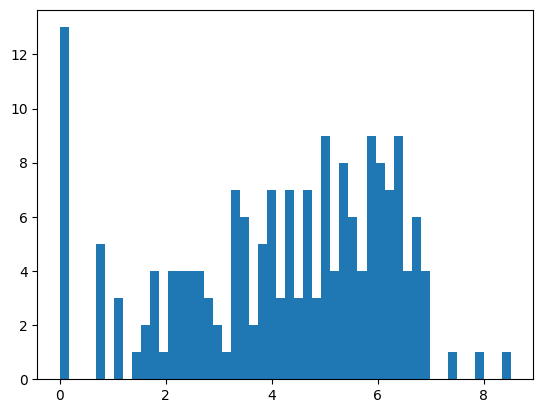

In [89]:
plt.hist(np.log(total_counts[total_counts>0]), bins=50)[2]

2.718281828459045


<BarContainer object of 20 artists>

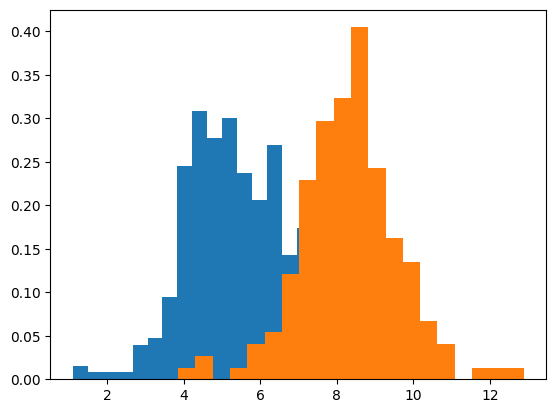

In [98]:
th = np.exp(1)
print(th)
plt.hist(voxel_counts[total_counts <= th].log().cpu().numpy(),density=True, bins=20)[2]
plt.hist(voxel_counts[total_counts > th].log().cpu().numpy(),density=True, bins=20)[2]

In [101]:
filt = (total_counts > 0) * (voxel_counts.cpu().numpy() > 100) # filter out too small voxel patchs and unrecognized voxel patchs

In [114]:
filt_total_grounded_sam_recognization = total_counts[filt]
filt_voxel_size = voxel_counts.cpu().numpy()[filt]
filt_labels = labels.unique(sorted=True)[filt]
filt_most_common_word = np.array(most_common_word)[filt]
filt_second_common_word = np.array(second_common_word)[filt]
filt_second_common_word[filt_second_common_word == filt_most_common_word] = ""
filt_most_common_word_counts = np.array(most_common_word_counts)[filt]
filt_second_common_word_counts = np.array(second_common_word_counts)[filt]

### Bounding Box

In [117]:
tsdf_device = "cuda:1"
tsdf_volume = FeatureFusionScalableTSDFVolume(
    voxel_size=0.015,
    sdf_trunc=0.075,
    margin=0.08,
    device="cuda:1",
)
tsdf_volume.load(save_dir + "tsdf/tsdf_volume.pt")

In [118]:
from core.integrate.utils.tsdf_ops import hash2discrete, discrete2world

In [135]:
# bboxes = []  # xyzhwd
# for label in filt_labels:
#     hashes = tsdf_volume._voxel_hash[labels == label]

#     world_c = discrete2world(
#         discrete_coord=hash2discrete(hashes),
#         voxel_size=tsdf_volume.voxel_size,
#         voxel_origin=tsdf_volume._vol_origin,
#     )

#     r = world_c.min(dim=0)[0]
#     dr = world_c.max(dim=0)[0] - world_c.min(dim=0)[0]

#     bboxes.append(r.tolist() + dr.tolist())

#     print(dr.tolist())

# bboxes = np.array(bboxes)

This bbox is very noisy, most of it have non localized voxels

In [149]:
import open3d as o3d

draw = o3d.visualization.EV.draw
pcd = o3d.geometry.PointCloud()

In [168]:
pcd.points = o3d.utility.Vector3dVector(
    discrete2world(
        discrete_coord=hash2discrete(tsdf_volume._voxel_hash),
        voxel_size=tsdf_volume.voxel_size,
        voxel_origin=tsdf_volume._vol_origin,
    )
    .cpu()
    .numpy()
)
pcd.colors = o3d.utility.Vector3dVector((labels != filt_labels[27]).float().reshape(-1, 1).expand(-1, 3).cpu().numpy())

In [169]:
# to visualize
# draw([pcd])

compare with LSeg

In [184]:
from torch.nn.functional import normalize
from core.labeler import CLIPTextQuerier

decap = DeCapCaptioner(
    decap_ckpt="/home/quanta/Models/decap/coco_prefix-009.pt",
    device=tsdf_device,
)
decap.load_model()
clip_text = CLIPTextQuerier(device=tsdf_device)
clip_text.load_model()

In [194]:
decoded_text = []
sim_decode = []
sim_most_common = []
sim_second_common = []
for i, label in enumerate(filt_labels):
    feat = normalize(lseg_feats[labels == label].mean(dim=0), dim=-1)

    text_decode = decap.get_caption(feat)
    emb = normalize(clip_text.encode_text(text_decode).squeeze(0), dim=-1)
    sim = torch.einsum("i,i->", emb.cpu(), feat.cpu())
    sim_decode.append(sim.item())
    decoded_text.append(text_decode)

    emb = normalize(clip_text.encode_text(filt_most_common_word[i]).squeeze(0), dim=-1)
    sim = torch.einsum("i,i->", emb.cpu(), feat.cpu())
    sim_most_common.append(sim.item())

    if str(filt_most_common_word[i]) != "":
        emb = normalize(clip_text.encode_text(filt_second_common_word[i]).squeeze(0), dim=-1)
        sim = torch.einsum("i,i->", emb.cpu(), feat.cpu())
        sim_second_common.append(sim.item())
    else:
        sim_second_common.append(0)
        print("!!!")

In [208]:
df = pd.DataFrame(
    zip(
        filt_labels.tolist(),
        filt_voxel_size,
        filt_total_grounded_sam_recognization,
        filt_most_common_word,
        filt_most_common_word_counts,
        filt_most_common_word_counts / filt_total_grounded_sam_recognization,
        sim_most_common,
        filt_second_common_word,
        filt_second_common_word_counts,
        filt_second_common_word_counts / filt_total_grounded_sam_recognization,
        sim_second_common,
        decoded_text,
        sim_decode,
    ),
    columns=[
        "label_id",
        "voxel_size",
        "recog_times",
        "most_common_word",
        "most_common_counts",
        "most_common_frac",
        "most_common_lseg_sim",
        "second_common_word",
        "second_common_counts",
        "second_common_frac",
        "second_common_lseg_sim",
        "lseg_decode",
        "decode_lseg_sim",
    ],
).sort_values(by=['voxel_size'], ascending=False)

In [210]:
df

,label_id,voxel_size,recog_times,most_common_word,most_common_counts,most_common_frac,most_common_lseg_sim,second_common_word,second_common_counts,second_common_frac,second_common_lseg_sim,lseg_decode,decode_lseg_sim
10,20,397842,1717,curtain,575,0.334886,0.924165,shower curtain,237,0.138031,0.784132,a wall with the word,0.885212
7,14,214293,4975,floor,4046,0.813266,0.894589,bag,207,0.041608,0.717892,a floor of a floor of a room,0.902900
0,0,124812,2687,carpet,648,0.241161,0.876939,pillow,443,0.164868,0.855180,a couch,0.931840
39,65,51560,1011,bed,569,0.562809,0.988740,blanket,72,0.071217,0.776335,a bed,0.961436
46,80,50930,105,tile wall,52,0.495238,0.836182,kitchen,28,0.266667,0.752575,the wall of a wall with a lot of other,0.907773
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,412,226,1,##sock,1,1.000000,0.789086,,1,1.000000,0.863692,a cabinet of the cabinet,0.935260
44,76,178,1,ceiling,1,1.000000,0.803734,,1,1.000000,0.850569,a curtain,0.966246
62,115,168,2,faucet,1,0.500000,0.790915,footstall,1,0.500000,0.828425,a door with some kind of wall,0.900741
164,450,167,2,toilet paper,2,1.000000,0.805034,,2,1.000000,0.852265,a refrigerator,0.945472


In [211]:
df_save_dir = '../05_panoptic_fusion/07_recog/'
os.makedirs(df_save_dir, exist_ok=True)
df.to_csv(df_save_dir + 'stats.csv', index=False)